In [1]:
from exp.expdata import LotkaVolterraExp
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

In [ ]:
noise=0.5
noise = 0.1
dt_train = 5.555
dt_train = 5.376
# dt_train = 5.6
t1=97.
t1=46.
t1=100.
# t1 = 300.
# t1=50.
expdata = LotkaVolterraExp(t0=0.,t1=t1,noise=noise, dt_train=dt_train,n_colloc=500, feature_names=['x','y'],seed=1234)

In [3]:
x_true = expdata.x_true
t_true = expdata.t_true

t_train = expdata.t_train
x_train = expdata.x_train
t_train.shape

(19,)

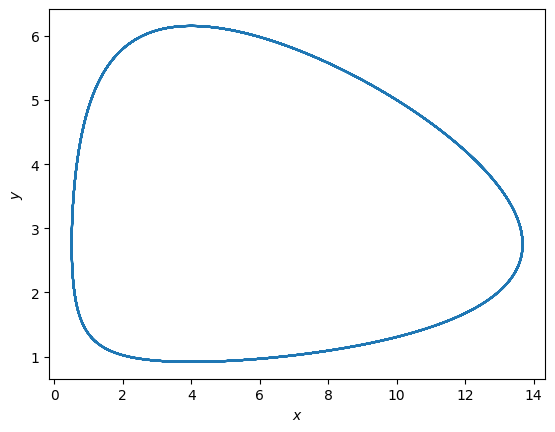

In [4]:
plt.plot(x_true[:,0], x_true[:,1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

In [5]:
t_train[-1]+dt_train, t_train

(Array(105.545, dtype=float64),
 Array([ 0.   ,  5.555, 11.11 , 16.665, 22.22 , 27.775, 33.33 , 38.885,
        44.44 , 49.995, 55.55 , 61.105, 66.66 , 72.215, 77.77 , 83.325,
        88.88 , 94.435, 99.99 ], dtype=float64))

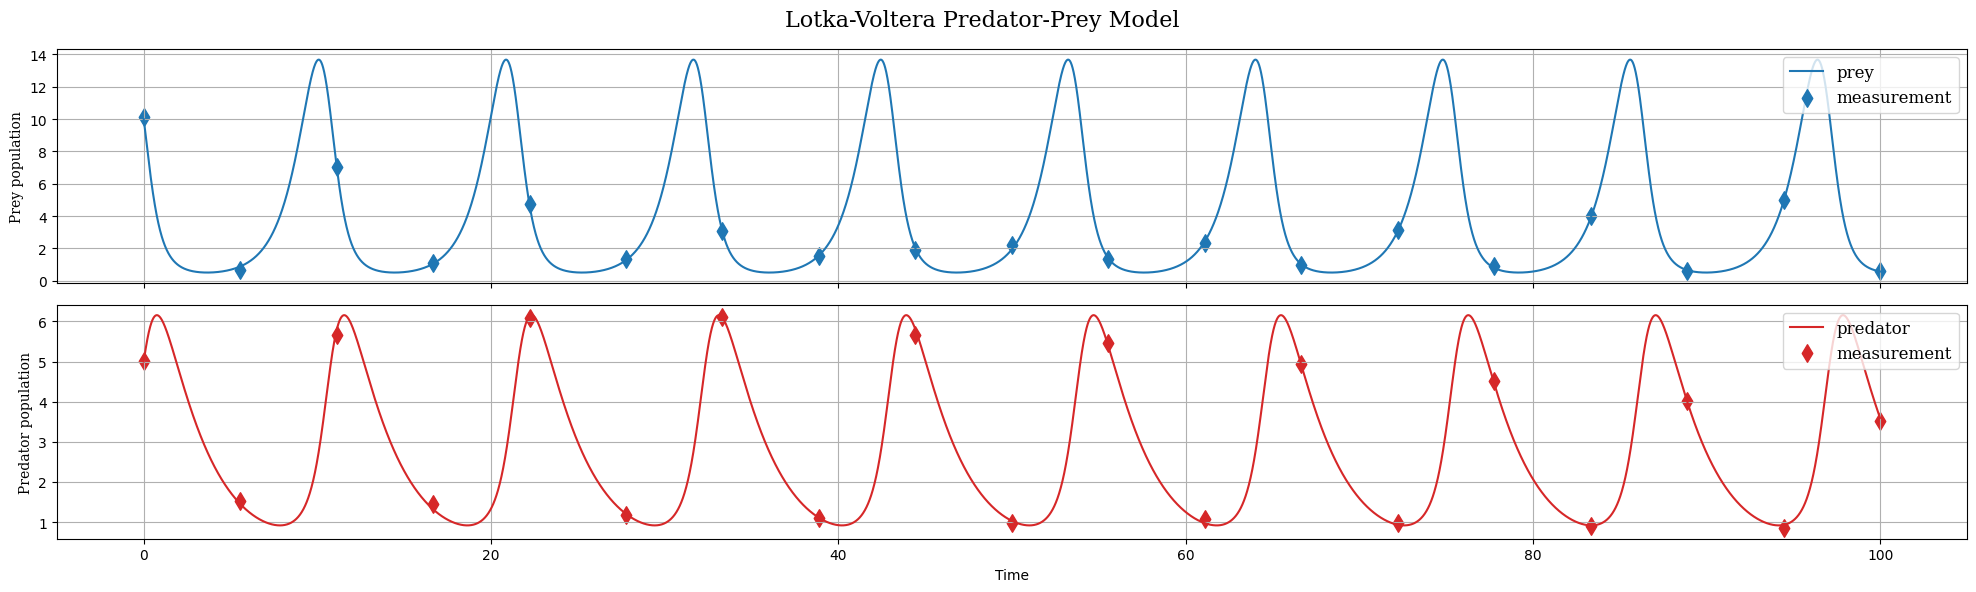

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="prey", c='tab:blue',)
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80)
ax1.set_ylabel("Prey population", fontname=fontname)
ax1.legend(loc='upper right',prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='tab:red', marker='d',s=80)
ax2.set_ylabel("Predator population", fontname=fontname)
ax2.set_xlabel("Time")
ax2.grid(True)
ax2.legend(loc='upper right',prop={'family': fontname, 'size':12})

plt.suptitle("Lotka-Voltera Predator-Prey Model", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

$$\dot x = \alpha x - \beta x y$$
$$\dot y = -\gamma y + \delta x y $$

where $\alpha = 1.1$, $\beta = 0.4$, $\gamma  = 0.4$, and $\delta = 0.1$.

In [7]:
expdata.print(precision=1)

(x)' = 1.1 x + -0.4 x y
(y)' = -0.4 y + 0.1 x y


In [8]:
X = x_true[:,0]
t = t_true
dt = t[1]-t[0]

In [9]:
Y = fft(X-np.mean(X))
Y_real = np.real(Y)
Y_imag = np.imag(Y)
freqs = fftfreq(len(t),dt)
pos_mask = freqs > 0
power = np.abs(Y[pos_mask])**2

In [10]:
peaks, _ = find_peaks(power)

In [11]:
power[peaks]

array([5.21214296e+08, 8.17481865e+07, 2.91574490e+07, 5.06130205e+06,
       6.39964602e+05, 2.28374187e+05, 7.95665591e+04, 5.14603982e+04,
       5.08955305e+04, 3.65651897e+04, 3.09711247e+04, 2.62214174e+04,
       2.22399298e+04, 1.89524877e+04])

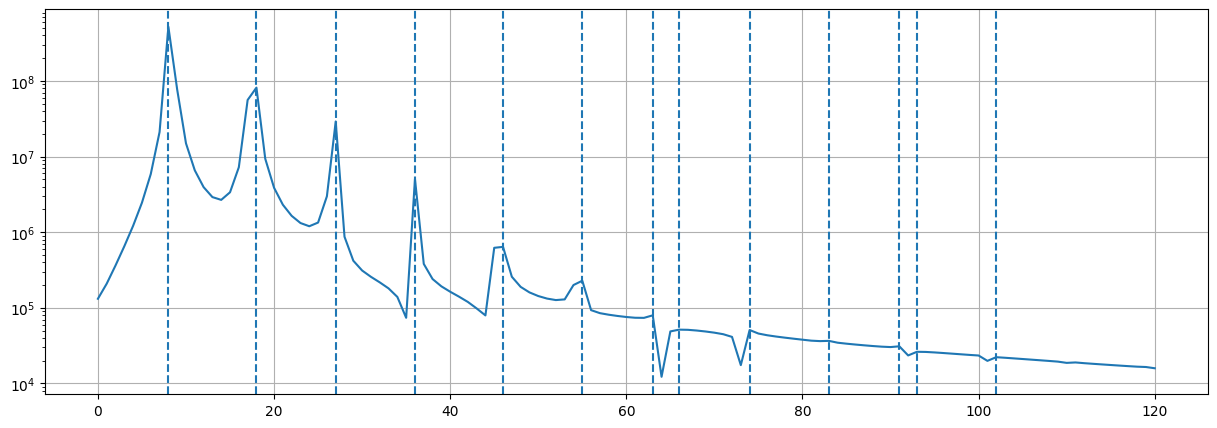

In [12]:
cutoff = -1
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(power[:peaks[cutoff]+10])
for peak in peaks[:cutoff]: 
    ax.axvline(peak, linestyle='--')
ax.grid(True)
ax.set_yscale('log')
plt.show()
# sampling slightly les than half the period

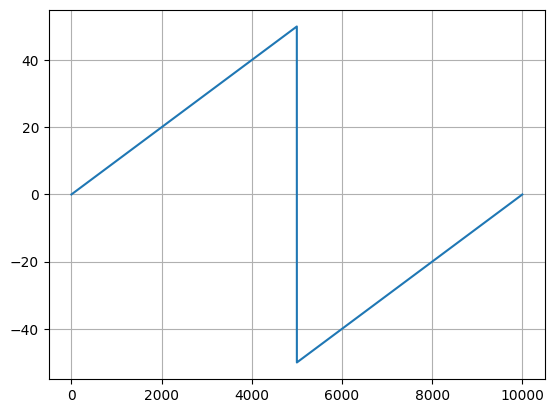

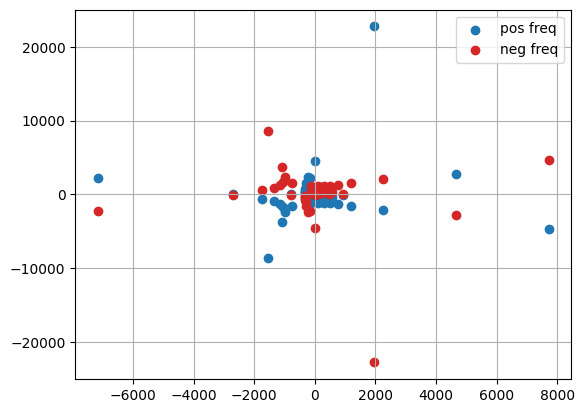

In [13]:
plt.plot(freqs)
plt.grid(True)
plt.show()
plt.scatter(Y_real[pos_mask],Y_imag[pos_mask],c='tab:blue', label='pos freq')
plt.scatter(Y_real[~pos_mask],Y_imag[~pos_mask],c='tab:red', label = 'neg freq')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

def get_nyquist_info(x, t, trim_start=0):
    # Trim initial time if needed
    mask = t > trim_start
    x = x[mask]
    t = t[mask]

    Y = fft(x - np.mean(x))
    dt = t[1] - t[0]
    freqs = fftfreq(len(t), dt)

    pos_mask = freqs > 0
    pos_freqs = freqs[pos_mask]
    power = np.abs(Y[pos_mask])**2

    f_max = pos_freqs[np.argmax(power)]
    nyquist_fs = 2 * f_max

    return f_max, nyquist_fs, power, pos_freqs


prey
Estimated dominant frequency: 0.090 Hz
Nyquist sampling frequency: 0.180 Hz
Sampling rate: 5.555 s
5.555000000000001
predator
Estimated dominant frequency: 0.090 Hz
Nyquist sampling frequency: 0.180 Hz
Sampling rate: 5.555 s


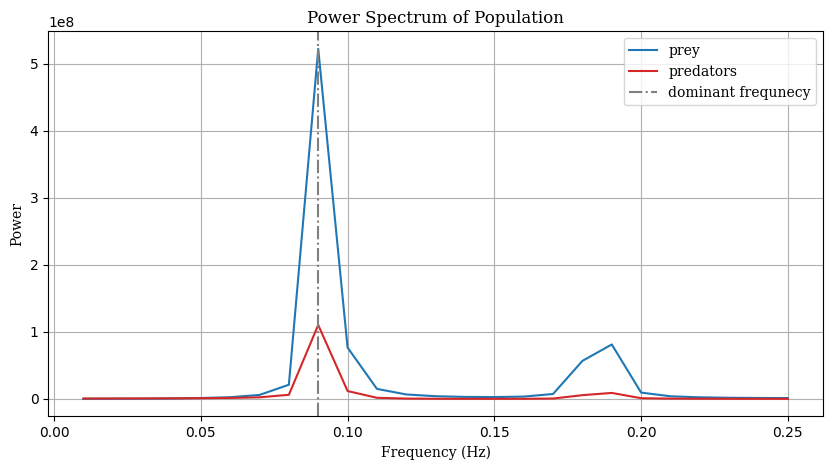

4999


In [15]:

# Assuming `sol` from earlier
# prey = x_true[:,0]
# t = t_true
# dt = t[1] - t[0]


f_max, nyquist_fs,power, pos_freqs = get_nyquist_info(x_true[:,0],t_true)
f_max2, nyquist_fs2,power2, pos_freqs2 = get_nyquist_info(x_true[:,1],t_true)

print("prey")
print(f"Estimated dominant frequency: {f_max:.3f} Hz")
print(f"Nyquist sampling frequency: {nyquist_fs:.3f} Hz")
print(f"Sampling rate: {1/nyquist_fs:.3f} s")
print(1/nyquist_fs)

print('predator')
print(f"Estimated dominant frequency: {f_max2:.3f} Hz")
print(f"Nyquist sampling frequency: {nyquist_fs2:.3f} Hz")
print(f"Sampling rate: {1/nyquist_fs2:.3f} s")

# Optional: Plot spectrum
family = 'serif'

fig, ax1 = plt.subplots(1,1, figsize= (10,5))

tot = len(power)
tot=25
ax1.plot(pos_freqs[:tot], power[:tot], label='prey')
ax1.plot(pos_freqs2[:tot],power2[:tot], c='tab:red', label='predators')
ax1.axvline(f_max, linestyle='-.', c='grey', label='dominant frequnecy')
ax1.set_xlabel("Frequency (Hz)",family=family)
ax1.set_ylabel("Power", family=family)
ax1.set_title("Power Spectrum of Population", family=family)
ax1.legend(prop = {'family': family})
ax1.grid(True)


plt.show()
print(len(power))

# How is nyquist frequency changing over time

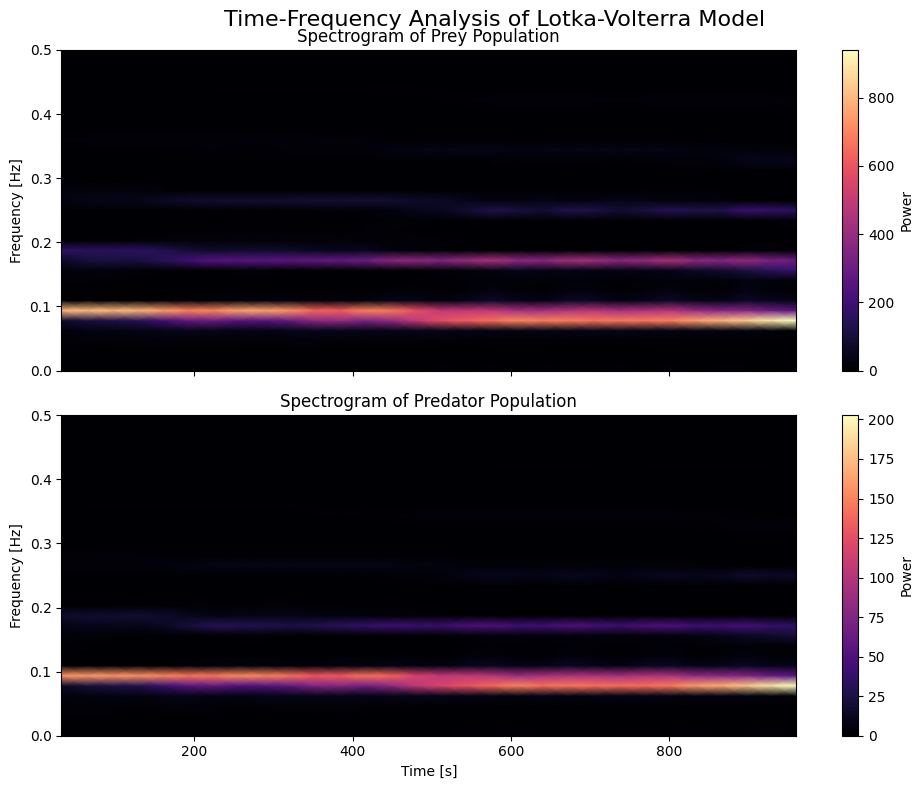

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram

# Lotka-Volterra parameters
alpha, beta, gamma, delta = 1.1, 0.4, 0.4, 0.1

def lotka_volterra(t, z):
    x, y = z
    return [alpha * x - beta * x * y, delta * x * y - gamma * y]

# Simulate system
x0, y0 = 10, 5
t_end = 1000
t_eval = np.linspace(0, t_end, 4000)
sol = solve_ivp(lotka_volterra, [0, t_end], [x0, y0], t_eval=t_eval)

prey = sol.y[0]
pred = sol.y[1]
t = sol.t
dt = t[1] - t[0]
fs = 1 / dt

# Compute spectrograms
f_prey, t_prey, Sxx_prey = spectrogram(prey, fs=fs, nperseg=256, noverlap=128)
f_pred, t_pred, Sxx_pred = spectrogram(pred, fs=fs, nperseg=256, noverlap=128)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

im1 = ax1.pcolormesh(t_prey, f_prey, Sxx_prey, shading='gouraud', cmap='magma')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_title('Spectrogram of Prey Population')
ax1.set_ylim(0, 0.5)
fig.colorbar(im1, ax=ax1, label='Power')

im2 = ax2.pcolormesh(t_pred, f_pred, Sxx_pred, shading='gouraud', cmap='magma')
ax2.set_ylabel('Frequency [Hz]')
ax2.set_xlabel('Time [s]')
ax2.set_title('Spectrogram of Predator Population')
ax2.set_ylim(0, 0.5)
fig.colorbar(im2, ax=ax2, label='Power')

plt.tight_layout()
plt.suptitle('Time-Frequency Analysis of Lotka-Volterra Model', fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()


# Learn Model

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
jax.config.update('jax_enable_x64',True)

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings, AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ
from jsindy.kernels import ConstantKernel, ScalarMaternKernel


In [18]:

kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   
kernel=None

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=2)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 20.
colloc_weight = 10. 
sparsifier = pySindySparsifier(STLSQ(threshold = 0.05,alpha = 0.01))
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-5,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)

In [19]:
from exp.evaluate.jsindy import evaluate_jmodel

In [20]:
metrics = evaluate_jmodel(model=model,expdata=expdata)
model.print()
metrics['xdot_metrics']

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.12681857, dtype=float64), 'data_weight': 20.0, 'colloc_weight': 10.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 15.04, gradnorm = 28.94, alpha = 4.167, improvement_ratio = 0.9724
Iteration 1, loss = 12.15, gradnorm = 6.748, alpha = 3.472, improvement_ratio = 1.007
Iteration 2, loss = 9.899, gradnorm = 3.356, alpha = 2.894, improvement_ratio = 1.01
Iteration 3, loss = 8.177, gradnorm = 3.121, alpha = 2.411, improvement_ratio = 1.015
Iteration 4, loss = 6.873, gradnorm = 2.652, alpha = 2.009, improvement_ratio = 1.019
Iteration 5, loss = 5.893, gradnorm = 2.394, alpha = 1.674, improvement_ratio = 1.023
Iteration 170, loss = 0.001585, gradnorm = 6.382e-09, alpha = 0.0001281, improvement_ratio = 3.822
Model after smooth warm start
(x)' = -0.090 1 + -0.514 x + -0.140 y + -0.011 x^2 + 0.205 x y + 0.035 y^2
(y)' = 1.281 1 + -0.365 x + -0.101 y + 0.009 x^2 + -0.076 x y + 0.040 y^2
Alternating Activeset Sparsifier
2 active coeffs changed
3 active coeffs changed
1 active coeffs changed
Active set stabilized
(x)' = -0.876 x + 0.307 x y
(y)' = 0.421 y + -0.128 x y


{'mse': Array(24.10974409, dtype=float64),
 'rmse': np.float64(4.910167420253007),
 'mae': np.float64(3.2704112068763926),
 'max_abs_error': np.float64(16.016296018159295),
 'normalized_mse': Array(3.37116961, dtype=float64),
 'relative_l2_error': np.float64(1.8356956023888078)}

In [37]:
metrics["xdot_metrics"]

{'mse': Array(24.10974409, dtype=float64),
 'rmse': np.float64(4.910167420252851),
 'mae': np.float64(3.2704112068763957),
 'max_abs_error': np.float64(16.01629601815834),
 'normalized_mse': Array(3.37116961, dtype=float64),
 'relative_l2_error': np.float64(1.8356956023887494)}

In [38]:
expdata.print()

(x)' = 1.100 x + -0.400 x y
(y)' = -0.400 y + 0.100 x y


In [39]:
x_pred = model.predict_state(expdata.t_true)
x_true = expdata.x_true

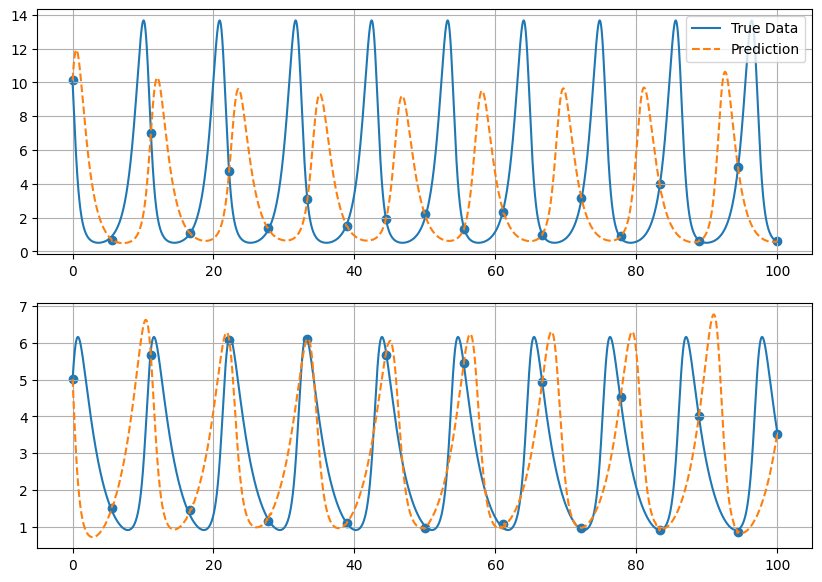

In [40]:
# for i in range(len(pred_sim.T)):
#     plt.scatter(t_train, x_train[:,i])
#     plt.plot(t_true, x_true[:,i], label='true')
#     # plt.plot(t_true, true[:,i])
#     plt.plot(t_true, pred_sim[:,i], label='pred', linestyle='--')
#     plt.legend()
#     plt.show()

fig, ax = plt.subplots(2,1, figsize=(10,7))

for idx in range(2):
    ax[idx].scatter(t_train, x_train[:,idx])
    ax[idx].plot(t_true, x_true[:,idx], label='True Data')
    ax[idx].plot(t_true, x_pred[:,idx], label='Prediction',linestyle='--')
    ax[idx].grid(True)
    if idx==0:
        ax[idx].legend()


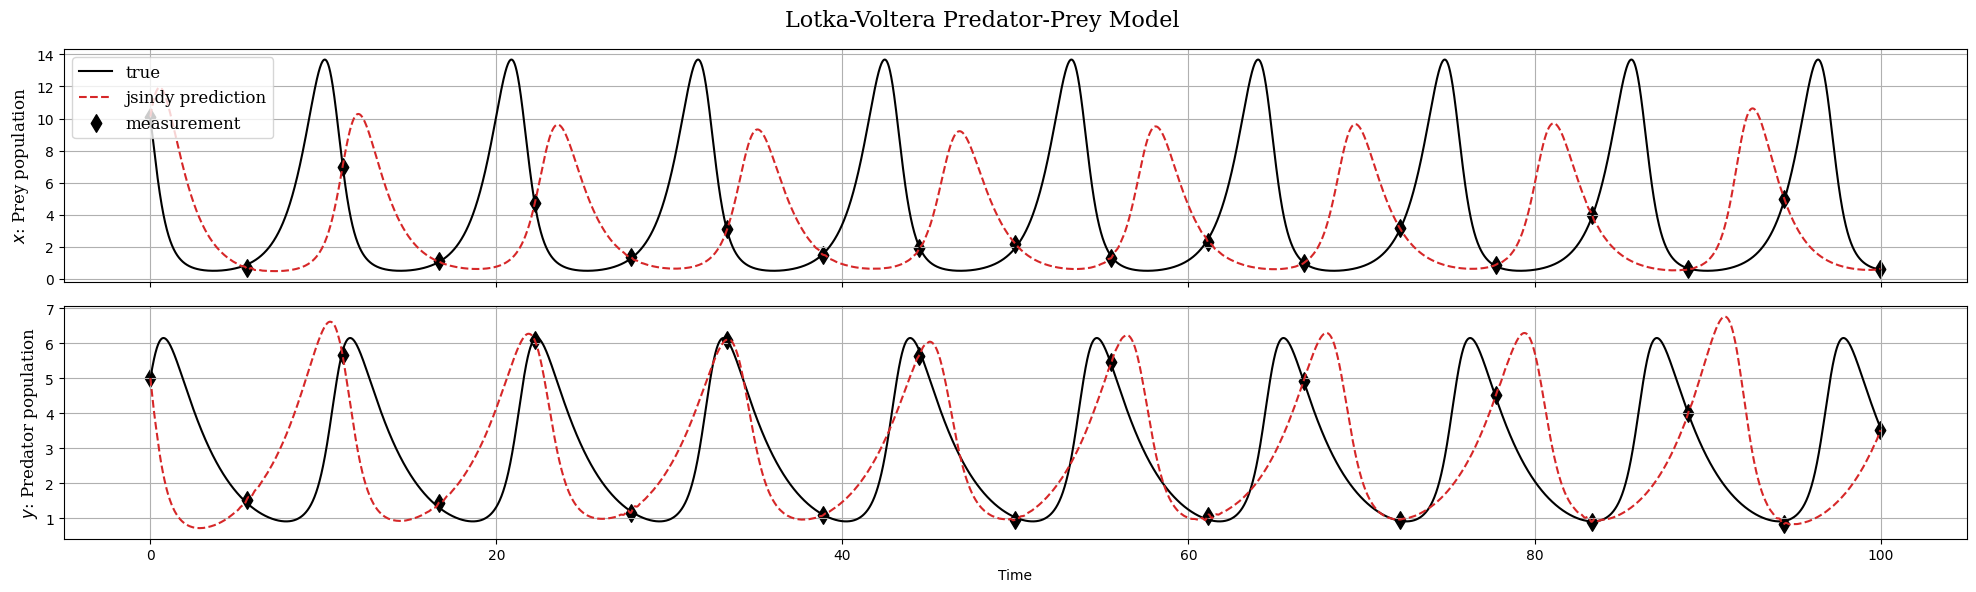

In [41]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="true", c='black',)
ax1.plot(t_true, x_pred[:,0], label='jsindy prediction',linestyle='--',c='tab:red')
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80,c='black')
ax1.set_ylabel(r"$x$: Prey population", fontname=fontname,size=12)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='black')
ax2.plot(t_true, x_pred[:,1], label='prediction', linestyle='--', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='black', marker='d',s=80)
ax2.set_ylabel(r"$y$: Predator population", fontname=fontname,size=12)
ax2.set_xlabel("Time")
ax2.grid(True)
# ax2.legend(prop={'family': fontname, 'size':12})

plt.suptitle("Lotka-Voltera Predator-Prey Model", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

In [42]:
xdot_pred = model.predict(expdata.x_true)
xdot_true = expdata.x_dot

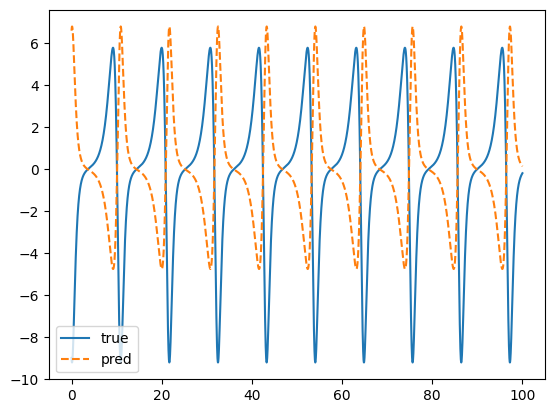

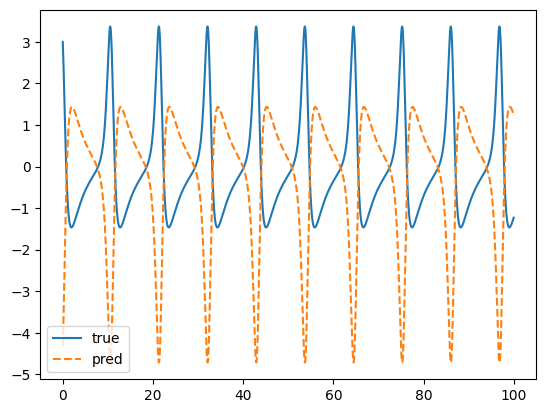

In [43]:
for i in range(len(xdot_pred.T)):
    plt.plot(t_true, xdot_true[:,i], label='true')
    plt.plot(t_true, xdot_pred[:,i], label='pred', linestyle='--')
    plt.legend()
    plt.show()

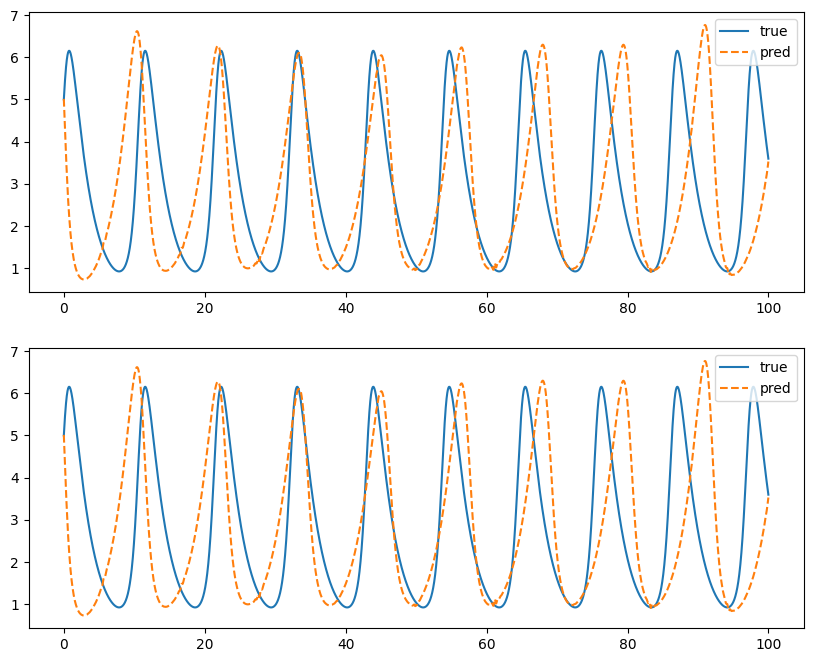

In [44]:
fig, ax = plt.subplots(2,1, figsize=(10,8))

for idx in range(2):
    # ax[idx].scatter(t_train, x_train[:,idx])
    ax[idx].plot(t_true, x_true[:,i], label='true')
    # plt.plot(t_true, true[:,i])
    ax[idx].plot(t_true, x_pred[:,i], label='pred', linestyle='--')
    ax[idx].legend()



In [45]:
import jax
from equinox import tree_pprint
tree_pprint(model.traj_model.kernel, short_arrays=False)
k1 = model.traj_model.kernel.kernels[1]


SumKernel(
  kernels=(
    ConstantKernel(raw_variance=Array(8.70176959, dtype=float64)),
    ScalarMaternKernel(
      core_matern=<function build_matern_core.<locals>.<lambda>>,
      p_order=5,
      raw_variance=Array(5.28708904, dtype=float64),
      raw_lengthscale=Array(-0.74479473, dtype=float64),
      min_lengthscale=0.01
    )
  )
)


In [46]:
jax.nn.softplus(k1.raw_lengthscale) + k1.min_lengthscale


Array(0.39854392, dtype=float64)

# Try Annealed Optimizer

In [31]:

kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   
kernel=None

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=2)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 20.
colloc_weight = 10.
sparsifier = pySindySparsifier(STLSQ(threshold = 0.05,alpha = 0.01))
optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=1e-5,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier,
        num_annealing_steps=4,
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)

In [32]:
metrics = evaluate_jmodel(model=model,expdata=expdata)
model.print()
metrics['xdot_metrics']

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.12681857, dtype=float64), 'data_weight': 20.0, 'colloc_weight': 10.0}
Solving for data_weight = 20.0, colloc_weight = 0.08 beta_reg = 8e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 0.1546, gradnorm = 16.6, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 0.1511, gradnorm = 0.7337, alpha = 3.472, improvement_ratio = 0.9997
Iteration 2, loss = 0.1504, gradnorm = 0.06495, alpha = 2.894, improvement_ratio = 0.9983
Iteration 3, loss = 0.1497, gradnorm = 0.04746, alpha = 2.411, improvement_ratio = 0.9988
Iteration 4, loss = 0.149, gradnorm = 0.04293, alpha = 2.009, improvement_ratio = 0.9994
Iteration 5, loss = 0.1482, gradnorm = 0.04134, alpha = 1.674, improvement_ratio = 0.9998
Iteration 89, loss = 0.0009461, gradnorm = 9.456e-09, alpha = 1.555e-05, improvement_ratio = 0.2518
Solving for data_weight = 20.0, colloc_weight = 0.4 beta_reg = 4e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 0.001269, gradnorm = 0.003112, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 0.001269, gradnorm = 0.0004821, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 0.001269, gradnorm = 0.0004603, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 0.001269, gradnorm = 0.0004586, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 0.001269, gradnorm = 0.0004567, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 0.001269, gradnorm = 0.0004545, alpha = 1.674, improvement_ratio = 1.0
Iteration 79, loss = 0.001155, gradnorm = 9.986e-09, alpha = 4.556e-05, improvement_ratio = 0.1555
Solving for data_weight = 20.0, colloc_weight = 2.0 beta_reg = 2e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 0.001866, gradnorm = 0.009328, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 0.001866, gradnorm = 0.0006479, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 0.001866, gradnorm = 0.0004888, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 0.001866, gradnorm = 0.0004825, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 0.001866, gradnorm = 0.0004758, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 0.001866, gradnorm = 0.0004685, alpha = 1.674, improvement_ratio = 1.0
Iteration 120, loss = 0.00144, gradnorm = 7.975e-09, alpha = 8.542e-05, improvement_ratio = 2.619
Solving for data_weight = 20.0, colloc_weight = 10.0 beta_reg = 1e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 0.002015, gradnorm = 0.0176, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 0.002014, gradnorm = 0.0009765, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 0.002014, gradnorm = 0.0005636, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 0.002014, gradnorm = 0.0005457, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 0.002014, gradnorm = 0.0005298, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 0.002014, gradnorm = 0.0005146, alpha = 1.674, improvement_ratio = 1.0
Iteration 129, loss = 0.001585, gradnorm = 9.061e-09, alpha = 5.932e-05, improvement_ratio = 0.08088
Model after smooth warm start
(x)' = -0.090 1 + -0.514 x + -0.140 y + -0.011 x^2 + 0.205 x y + 0.035 y^2
(y)' = 1.281 1 + -0.365 x + -0.101 y + 0.009 x^2 + -0.076 x y + 0.040 y^2
Alternating Activeset Sparsifier
2 active coeffs changed
3 active coeffs changed
1 active coeffs changed
Active set stabilized
(x)' = -0.876 x + 0.307 x y
(y)' = 0.421 y + -0.12

{'mse': Array(24.10974409, dtype=float64),
 'rmse': np.float64(4.910167420252851),
 'mae': np.float64(3.2704112068763957),
 'max_abs_error': np.float64(16.01629601815834),
 'normalized_mse': Array(3.37116961, dtype=float64),
 'relative_l2_error': np.float64(1.8356956023887494)}

In [33]:
expdata.print()
x_pred = model.predict_state(expdata.t_true)
x_true = expdata.x_true

(x)' = 1.100 x + -0.400 x y
(y)' = -0.400 y + 0.100 x y


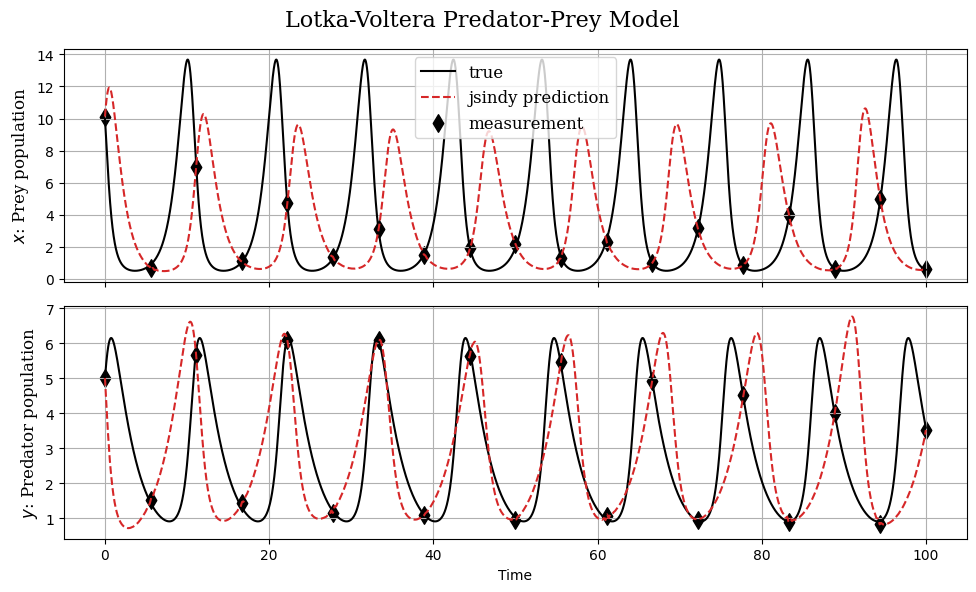

In [34]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="true", c='black',)
ax1.plot(t_true, x_pred[:,0], label='jsindy prediction',linestyle='--',c='tab:red')
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80,c='black')
ax1.set_ylabel(r"$x$: Prey population", fontname=fontname,size=12)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='black')
ax2.plot(t_true, x_pred[:,1], label='prediction', linestyle='--', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='black', marker='d',s=80)
ax2.set_ylabel(r"$y$: Predator population", fontname=fontname,size=12)
ax2.set_xlabel("Time")
ax2.grid(True)
# ax2.legend(prop={'family': fontname, 'size':12})

plt.suptitle("Lotka-Voltera Predator-Prey Model", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

# E-SINDy

In [35]:
import pysindy as ps

In [36]:
t_train[-1]+dt_train

Array(105.545, dtype=float64)